In [1]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from helper_code_qutip import *
from scipy import integrate
import scipy.io

In [70]:
Tc_list = [0.001,0.18,0.20]
Th_list = [0.2,0.3,0.4,0.7,1.0]


betalist1 = [1/Tc for Tc in Tc_list]
betalist2 = [1/Th for Th in Th_list]

elist = np.linspace(0,0.05,20)

print(len(betalist1),len(betalist2))

redfield_ss = []
lle_ss = []
lle_ss2 = []
g = 1.6e-3
for beta2 in betalist2:
    list_red = []
    list_lle = []
    list_lle2 = []
    for e in elist:
        limit_value=700
        b=500
        N=2
        w0min=1
        w0max=w0min+e
        delta=1
        gmin=1.6e-3
        gmax=1.6e-3
        beta1 = 1/0.05  #Tc = 0.1
            
        w0list=np.linspace(w0min,w0max,N)
        glist=np.linspace(gmin,gmax,N-1)

        g = glist[0]
            
        tb=0.01
        epsilon=1
        gamma1=1e-3 #gamma1 is the coupling to left bath. It shows up in spectral bath function
        gamma2=1.1e-2   #gamma2 is the coupling to the right bath.    
            
            

        mu=0
            
            
        delta=1
        mu1=mu
        mu2=mu

        H_S=create_hamiltonian2(w0list,glist,N)
    
    
        c_N=create_sm(N,N)  # we couple the Nth spin to the bath
        c_1=create_sm(N,1)
        
        
        
        eigenergies,eigstates=H_S.eigenstates()
        
        #print("eigenenergies are : ",eigenergies)
        
        spectrum=max(eigenergies)-min(eigenergies)
        
        
        
        number=len(eigenergies)

        integral11=np.empty((number,number),dtype=np.cdouble) #stores J * N integral for left bath
        integral12=np.empty((number,number),dtype=np.cdouble) # stores J integral (just to check) for the left bath
        integral21=np.empty((number,number),dtype=np.cdouble) #stores J*N integral for right bath
        integral22=np.empty((number,number),dtype=np.cdouble)

        print("Integral calculations at beta2 = {} and e = {} are : ".format(beta2,e))

        for i in range(number):
            for k in range(number):
                freq=eigenergies[k]-eigenergies[i]
                print(f"Absolute frequency  for i = {i}, k = {k} is ",np.absolute(freq))
                #print(i,k,freq)
                if( np.absolute(freq) >= 1/10**10):
                    integral11[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta2,mu2,gamma1),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0] #func 1
                    integral12[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma1),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0]  #left bath done
                    integral21[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta1,mu1,gamma2),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0] #func 1
                    integral22[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma2),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0]  #right bath
        
                if (np.absolute(freq)<=1/10**10):  #The problem is arising here....
                    integral11[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,b,args=(tb,beta2,mu2,gamma1),limit=limit_value)[0]
                    integral12[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath_2,0,b,args=(tb,gamma1),limit=limit_value)[0]
                    integral21[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,b,args=(tb,beta1,mu1,gamma2),limit=limit_value)[0]
                    integral22[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath_2,0,b,args=(tb,gamma2),limit=limit_value)[0]
                
            
            #expected=1.0j*(eigenergies[k]-eigenergies[i])/(2*tb*tb)
        #        print(i,k,integral2[i,k],expected)
    
    
        # PAY ATTENTION TO THE WAY THESE COEFFICIENTS ARE BEING COMPUTED
    
        constant12=np.empty((number,number),dtype=np.cdouble)
        constant11=np.empty((number,number),dtype=np.cdouble)
        constant21=np.empty((number,number),dtype=np.cdouble)
        constant22=np.empty((number,number),dtype=np.cdouble)
        
        
        
        for i in range(number):
            for k in range(number):
                constant12[i,k]=integral12[i,k]+integral11[i,k]+0.5*(spectral_bath(eigenergies[k]-eigenergies[i],tb,gamma1)+func1(eigenergies[k]-eigenergies[i],tb,beta2,mu2,gamma1))    #full coefficient created this is nbar+1
                constant11[i,k]=integral11[i,k]+0.5*func1(eigenergies[k]-eigenergies[i],tb,beta2,mu2,gamma1)                                       # the full coefficient is created
                
                constant22[i,k]=integral22[i,k]+integral21[i,k]+0.5*(spectral_bath(eigenergies[k]-eigenergies[i],tb,gamma2)+func1(eigenergies[k]-eigenergies[i],tb,beta1,mu1,gamma2))    #full coefficient created this is nbar+1
                constant21[i,k]=integral21[i,k]+0.5*func1(eigenergies[k]-eigenergies[i],tb,beta1,mu1,gamma2)   # the full coefficient is created
                #print(i,k,constant11[i,k],constant12[i,k],constant21[i,k],constant22[i,k])
        list1=[]
        list2=[]
        
        
        for i in range(number):
            list1.append([])
            list2.append([])
        
        
        
        matrix=np.zeros((number,number))
        
        dim=[]
        for k in range(N):
            dim.append(2)    
        
        zeromatrix=Qobj(matrix,dims=[dim,dim])
        
        
        indices1=[]
        indices2=[]
        
        
        
        
        for i in range(number):
            for k in range(number):
                list1[i].append(eigstates[i]*eigstates[i].dag()*c_1*eigstates[k]*eigstates[k].dag())
                list2[i].append(eigstates[i]*eigstates[i].dag()*c_N*eigstates[k]*eigstates[k].dag())
                
                if(tracedist(eigstates[i]*eigstates[i].dag()*c_1*eigstates[k]*eigstates[k].dag(),zeromatrix)!=0):
                    indices1.append((i,k))
                if(tracedist(eigstates[i]*eigstates[i].dag()*c_N*eigstates[k]*eigstates[k].dag(),zeromatrix)!=0):
                    indices2.append((i,k))

        pre=-1.0j*H_S
        post=1.0j*H_S
        
        L=spre(pre)+spost(post)
        
        for i in range(number):
            for k in range(number):
                vi=eigstates[i]
                vk=eigstates[k]

                print(constant11[i,k],constant12[i,k])
                
                op1=epsilon*epsilon*constant11[i,k]*vi*vi.dag()*c_1*vk*vk.dag()*c_1.dag()
                op2=epsilon*epsilon*constant12[i,k]*c_1.dag()*vi*vi.dag()*c_1*vk*vk.dag()
                
                op3=epsilon*epsilon*constant11[i,k]*c_1.dag()
                op4=vi*vi.dag()*c_1*vk*vk.dag()
                op5=epsilon*epsilon*constant12[i,k]*c_1.dag()
                
                
                L=L+spre(-op2-op1.dag())+spost(-op1-op2.dag())
                L=L+spre(op3)*spost(op4)+spre(op4)*spost(op5)+spre(op4.dag())*spost(op3.dag()) +spre(op5.dag())*spost(op4.dag())
                
                op1=epsilon*epsilon*constant21[i,k]*vi*vi.dag()*c_N*vk*vk.dag()*c_N.dag()
                op2=epsilon*epsilon*constant22[i,k]*c_N.dag()*vi*vi.dag()*c_N*vk*vk.dag()
                
                op3=epsilon*epsilon*constant21[i,k]*c_N.dag()
                op4=vi*vi.dag()*c_N*vk*vk.dag()
                op5=epsilon*epsilon*constant22[i,k]*c_N.dag()
                
                
                L=L+spre(-op2-op1.dag())+spost(-op1-op2.dag())
                L=L+spre(op3)*spost(op4)+spre(op4)*spost(op5)+spre(op4.dag())*spost(op3.dag()) +spre(op5.dag())*spost(op4.dag())
                
                
                
        #Variables needed for for iterative-lgmres to work. 
        return_info=True
        #print('Redfield Liouvillian constructed, Computing steady-state ...')
        ss_redfield = steadystate(L,return_info=return_info)
        L_eigen = L.eigenenergies()
        print("Smallest eigenvalues of L_red are ", L_eigen[-3:])
        list_red.append(ss_redfield)
        
        
        
        
        #H=H_S  #+(Deltadash1+0.5*Delta1)*create_sigmaz(N,1)+(DeltadashN+0.5*DeltaN)*create_sigmaz(N,N)
        
        
        """Cops=[]
        
        Cops.append(epsilon*np.sqrt(nbar(w0list[0],beta2,mu) + 1)*create_sm(N,1)) #epsilon is set to 1
        Cops.append(epsilon*np.sqrt(nbar(w0list[0],beta2,mu))*create_sm(N, 1).dag())
        Cops.append(epsilon*np.sqrt(nbar(w0list[N-1],beta1,mu) + 1)*create_sm(N,N))
        Cops.append(epsilon*np.sqrt(nbar(w0list[N-1],beta1,mu))*create_sm(N,N).dag())
        return_info = True
        
        
        #print('Local-Lindblad Liouvillian constructed, Computing steady-state ..')
        ss_lindblad=steadystate(H,Cops,return_info=return_info)  #Does not give correct steady state"""

        gammah_plus =  gamma1*nbar(1,beta2,mu)
        gammah_minus = gamma1*(nbar(1,beta2,mu)+1)
        gammac_plus = gamma2*nbar(1+e,beta1,mu)  #beta1 is fixed at 1/0.1
        gammac_minus = gamma2*(nbar(1+e,beta1,mu)+1)

        L = spre(-1.0j*(H_S)) + spost(1.0j*(H_S))
        op1 = create_sm(N,1).dag()
        op2 = create_sm(N,N).dag()
        L = L + gammah_plus*(spre(op1)*spost(op1.dag()) - 0.5*spre(op1.dag()*op1) - 0.5*spost(op1.dag()*op1)) + gammah_minus*(spre(op1.dag())*spost(op1) - 0.5*spre(op1*op1.dag()) - 0.5*spost(op1*op1.dag())) + gammac_plus*(spre(op2)*spost(op2.dag()) - 0.5*spre(op2.dag()*op2) - 0.5*spost(op2.dag()*op2)) + gammac_minus*(spre(op2.dag())*spost(op2) - 0.5*spre(op2*op2.dag()) - 0.5*spost(op2*op2.dag()))

        ss_lindblad2 = steadystate(L)
        L_eigen = L.eigenenergies()
        print("Smallest eigenvalues of L_lle are ", L_eigen[-3:])

        list_lle.append(ss_lindblad2)

        ########################## Another Local Lindblad version, with bath and spectral functions involved ###############################

        Delta1=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma1),weight='cauchy',wvar=w0list[0])[0] #Delta
        Deltadash1=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta1,mu1,gamma1),weight='cauchy',wvar=w0list[0])[0] #Delta
        
        
        DeltaN=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma2),weight='cauchy',wvar=w0list[N-1])[0] #Delta
        DeltadashN=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta2,mu2,gamma2),weight='cauchy',wvar=w0list[N-1])[0] #Delta

        H=H_S  +(Deltadash1+0.5*Delta1)*create_sigmaz(N,1)+(DeltadashN+0.5*DeltaN)*create_sigmaz(N,N) 

        L_lle = spre(-1.0j*(H)) + spost(1.0j*(H))
        op1 = create_sm(N,1).dag()
        op2 = create_sm(N,N).dag()
        L_lle = L_lle + gammah_plus*(spectral_bath(1,tb,1))*(spre(op1)*spost(op1.dag()) - 0.5*spre(op1.dag()*op1) - 0.5*spost(op1.dag()*op1)) + gammah_minus*(spectral_bath(1,tb,1))*(spre(op1.dag())*spost(op1) - 0.5*spre(op1*op1.dag()) - 0.5*spost(op1*op1.dag())) + gammac_plus*(spectral_bath(1+e,tb,1))*(spre(op2)*spost(op2.dag()) - 0.5*spre(op2.dag()*op2) - 0.5*spost(op2.dag()*op2)) + gammac_minus*(spectral_bath(1+e,tb,1))*(spre(op2.dag())*spost(op2) - 0.5*spre(op2*op2.dag()) - 0.5*spost(op2*op2.dag()))

        ss_lindblad = steadystate(L_lle)
        L_eigen = L_lle.eigenenergies()
        print("Smallest eigenvalues of L_lle2 are ", L_eigen[-3:])

        list_lle2.append(ss_lindblad)



        #list_lle.append(ss_lindblad)
    #lle_ss.append(list_lle)
    lle_ss.append(list_lle)
    lle_ss2.append(list_lle2)
    redfield_ss.append(list_red)

3 5
Integral calculations at beta2 = 5.0 and e = 0.0 are : 
Absolute frequency  for i = 0, k = 0 is  0.0
Absolute frequency  for i = 0, k = 1 is  0.9984
Absolute frequency  for i = 0, k = 2 is  1.0016
Absolute frequency  for i = 0, k = 3 is  2.0
Absolute frequency  for i = 1, k = 0 is  0.9984
Absolute frequency  for i = 1, k = 1 is  0.0
Absolute frequency  for i = 1, k = 2 is  0.0032000000000000917
Absolute frequency  for i = 1, k = 3 is  1.0016
Absolute frequency  for i = 2, k = 0 is  1.0016
Absolute frequency  for i = 2, k = 1 is  0.0032000000000000917
Absolute frequency  for i = 2, k = 2 is  0.0
Absolute frequency  for i = 2, k = 3 is  0.9984
Absolute frequency  for i = 3, k = 0 is  2.0
Absolute frequency  for i = 3, k = 1 is  1.0016
Absolute frequency  for i = 3, k = 2 is  0.9984
Absolute frequency  for i = 3, k = 3 is  0.0
0.008557456255238509j 0.007146982296369118j
(3.3799267216861796e-06+1.611165063268747e-05j) (0.0004976286067816187-0.0016827424468204182j)
(3.3363636700409266e-

c:\Users\DELL\OneDrive\Desktop\Term paper and Proj report\ICTS Project\SearchingLindbladians\python\helper_code_qutip.py:196: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(beta*(omega-mu))-1)
c:\Users\DELL\OneDrive\Desktop\Term paper and Proj report\ICTS Project\SearchingLindbladians\python\helper_code_qutip.py:196: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(np.exp(beta*(omega-mu))-1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_38144\1380997631.py:87: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral11[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,b,args=(tb,beta2,mu2,gamma1),limit=limit_value)[0]
C:\Users\DELL\AppData\Local\Temp\ipykernel_38144\1380997631.py:89: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral21[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,b,args=(tb,beta1,mu1,gamma2),limit=limit_value)[0]


Absolute frequency  for i = 1, k = 2 is  0.00414309156985837
Absolute frequency  for i = 1, k = 3 is  1.0033873352586133
Absolute frequency  for i = 2, k = 0 is  1.0033873352586133
Absolute frequency  for i = 2, k = 1 is  0.00414309156985837
Absolute frequency  for i = 2, k = 2 is  0.0
Absolute frequency  for i = 2, k = 3 is  0.999244243688755
Absolute frequency  for i = 3, k = 0 is  2.0026315789473683
Absolute frequency  for i = 3, k = 1 is  1.0033873352586133
Absolute frequency  for i = 3, k = 2 is  0.999244243688755
Absolute frequency  for i = 3, k = 3 is  0.0
0.008557456255238509j 0.007146982296369118j
(3.3683815594185943e-06+1.6095408510332875e-05j) (0.0004980266541692884-0.0016828394559304529j)
(3.312264196099794e-06+1.6015960186366118e-05j) (0.0004999802906716106-0.0016833128993697306j)
(4.310362338690183e-08+6.359813527084705e-06j) (0.0009619954093149591-0.0016917879031231274j)
-8.388533866896405e-06j -0.0010744413717579397j
0.008557456255238509j 0.007146982296369118j
(9.896778

In [45]:
#create_sm(1,1)
fock(2,1)*fock(2,0).dag()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]

In [46]:
def concurrence_plot(Th_list,elist,reduced_dm_list):
    for i in range(len(Th_list)):
        concurrence_list = []
        for j in range(len(elist)):
            concurrence_list.append(concurrence(reduced_dm_list[i][j]))
            #print(f'Concurrence Qutip for Tc = {Tc_list[i]} and Th = {round(Th_list[j],2)}: ',concurrence(reduced_dm_list[i][j]))
        plt.plot(elist,concurrence_list,label='Th/Eh = '+str(Th_list[i]))

    plt.xlabel('delta/Eh')
    plt.ylabel('Concurrence')
    plt.title(f'Concurrence (LLE) for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()


def negativity1(rho):
    a1 = rho[0,0]
    a4 = rho[3,3]
    c = np.abs(rho[1,2])
    val = 0.5*(np.sqrt(4*c**2 + (a1-a4)**2) - (a1+a4))  #How did it know the function?? Very cool
    if val < 0:
        return 0
    else:
        return val

def negativity_plot(Th_list,elist,reduced_dm_list):
    for i in range(len(Th_list)):
        neg_list = []
        for j in range(len(elist)):
            neg_list.append(negativity1(reduced_dm_list[i][j]))
        plt.plot(elist,neg_list,label='Th/Eh = '+str(Th_list[i]))

    plt.xlabel('delta/Eh')
    plt.ylabel('Negativity')
    plt.title(f'Negativity vs delta for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

def check_ss(rho,e,beta2):
    gammah_plus =  gamma1*nbar(1,beta2,mu)
    gammah_minus = gamma1*(nbar(1,beta2,mu)+1)
    gammac_plus = gamma2*nbar(1+e,beta1,mu)  #beta1 is fixed at 1/0.1
    gammac_minus = gamma2*(nbar(1+e,beta1,mu)+1)

    Gamma = gammah_plus + gammah_minus + gammac_plus + gammac_minus
    Gammah = gammah_plus + gammah_minus
    Gammac = gammac_plus + gammac_minus
    chi = (4*g**2 + Gammah*Gammac)*Gamma**2 + 4*e**2*Gammah*Gammac

    r1 = (4*g**2*(gammah_plus+gammac_plus)**2 + gammah_plus*gammac_plus*(Gamma**2 + 4*e**2))/chi
    r2 = (4*g**2*(gammah_minus+gammac_minus)*(gammah_plus+gammac_plus) + gammah_plus*gammac_minus*(Gamma**2 + 4*e**2))/chi
    r3 = (4*g**2*(gammah_plus+gammac_plus)*(gammah_minus+gammac_minus) + gammah_minus*gammac_plus*(Gamma**2 + 4*e**2))/chi
    r4 = (4*g**2*(gammah_minus+gammac_minus)**2 + gammah_minus*gammac_minus*(Gamma**2 + 4*e**2))/chi

    c = 2*g*(gammah_plus*gammac_minus - gammah_minus*gammac_plus)*(1j*Gamma - 2*e)/chi

    print("r1: ",r1)
    print("r2: ",r2)
    print("r3: ",r3)
    print("r4: ",r4)
    print("c: ",c)

    a1 = rho[0,0]
    a2 = rho[1,1]
    a3 = rho[2,2]
    a4 = rho[3,3]
    a = rho[1,2]

    print("a1: ",a1)
    print("a2: ",a2)
    print("a3: ",a3)
    print("a4: ",a4)
    print("a: ",a)

    rho_new = np.array([[r1,0,0,0],[0,r2,c,0],[0,c.conjugate(),r3,0],[0,0,0,r4]])

    return rho_new

def create_ss(beta2,e):
    gammah_plus =  gamma1*nbar(1,beta2,mu)
    gammah_minus = gamma1*(nbar(1,beta2,mu)+1)
    gammac_plus = gamma2*nbar(1+e,beta1,mu)  #beta1 is fixed at 1/0.1
    gammac_minus = gamma2*(nbar(1+e,beta1,mu)+1)

    Gamma = gammah_plus + gammah_minus + gammac_plus + gammac_minus
    Gammah = gammah_plus + gammah_minus
    Gammac = gammac_plus + gammac_minus
    chi = (4*g**2 + Gammah*Gammac)*Gamma**2 + 4*e**2*Gammah*Gammac

    r1 = (4*g**2*(gammah_plus+gammac_plus)**2 + gammah_plus*gammac_plus*(Gamma**2 + 4*e**2))/chi
    r2 = (4*g**2*(gammah_minus+gammac_minus)*(gammah_plus+gammac_plus) + gammah_plus*gammac_minus*(Gamma**2 + 4*e**2))/chi
    r3 = (4*g**2*(gammah_plus+gammac_plus)*(gammah_minus+gammac_minus) + gammah_minus*gammac_plus*(Gamma**2 + 4*e**2))/chi
    r4 = (4*g**2*(gammah_minus+gammac_minus)**2 + gammah_minus*gammac_minus*(Gamma**2 + 4*e**2))/chi

    c = 2*g*(gammah_plus*gammac_minus - gammah_minus*gammac_plus)*(1j*Gamma - 2*e)/chi

    rho_new = np.array([[r1,0,0,0],[0,r2,c,0],[0,c.conjugate(),r3,0],[0,0,0,r4]])
    rho_new = Qobj(rho_new)
    rho_new.dims = [[2,2],[2,2]]
    return Qobj(rho_new)




In [5]:
print()

In [47]:
lle_ss[1][2]


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.63618242e-04+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          1.50734665e-01+0.j
  -1.80121878e-02+0.02161418j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -1.80121878e-02-0.02161418j
   6.16667205e-03+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          8.42935044e-01+0.j        ]]

In [7]:
lle_ss2[1][2]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[9.46871593e-05+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         1.69403697e-01+0.j
  1.90676522e-02+0.01201683j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         1.90676522e-02-0.01201683j
  3.46090202e-03+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         8.27040714e-01+0.j        ]]

In [48]:
i = 1
j = 2

rho_new = check_ss(lle_ss2[i][j],elist[j],betalist2[i])

r1:  0.0001636182419405106
r2:  0.1507346654963261
r3:  0.006166672054486617
r4:  0.8429350442072465
c:  (-0.018012187837345782+0.021614180268229442j)
a1:  (9.46871593438757e-05+0j)
a2:  (0.16940369672136538+0j)
a3:  (0.0034609020229986243+0j)
a4:  (0.8270407140962921+0j)
a:  (0.0190676522373497+0.012016825660812665j)


In [49]:
print("rho_new: ",rho_new)

rho_new:  [[ 1.63618242e-04+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          1.50734665e-01+0.j
  -1.80121878e-02+0.02161418j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -1.80121878e-02-0.02161418j
   6.16667205e-03+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          8.42935044e-01+0.j        ]]


In [50]:
#convert np arr to qutip qobj
rho_new = Qobj(rho_new)
val = negativity1(rho_new)

print(val)

(0.0007746330555005176+0j)


In [51]:
def negativity2_plot(Th_list,elist):
    for i in range(len(Th_list)):
        neg_list = []
        for j in range(len(elist)):
            neg_list.append(negativity1(create_ss(betalist2[i],elist[j])))
        plt.plot(elist,neg_list,label='Th/Eh = '+str(Th_list[i]))

    plt.xlabel('delta/Eh')
    plt.ylabel('Negativity')
    plt.title(f'Negativity (LLE) for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


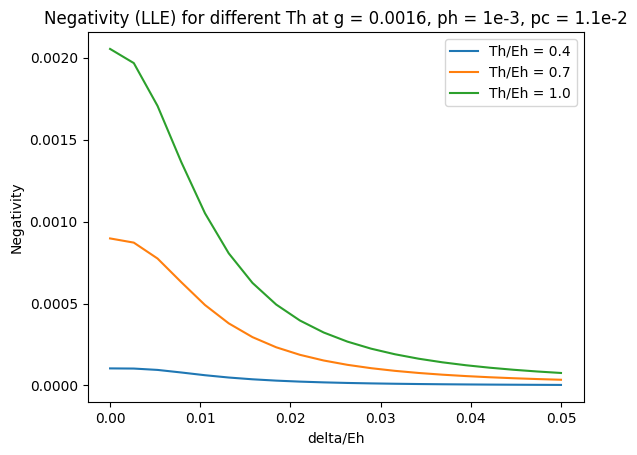

In [52]:
negativity2_plot(Th_list,elist)

d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Anaconda\envs\qiskitenv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


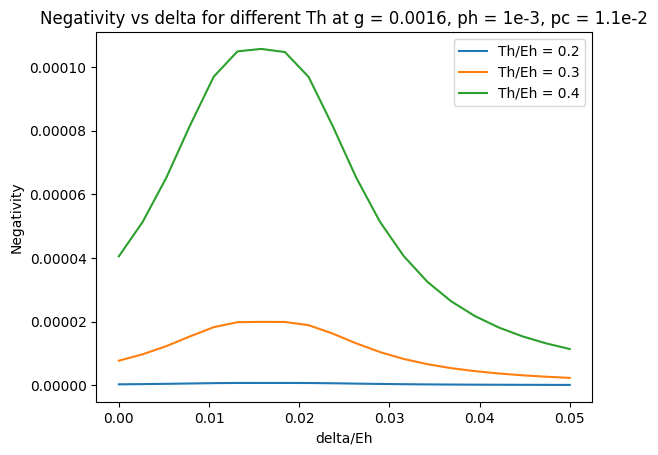

In [68]:
negativity_plot(Th_list,elist,lle_ss2)

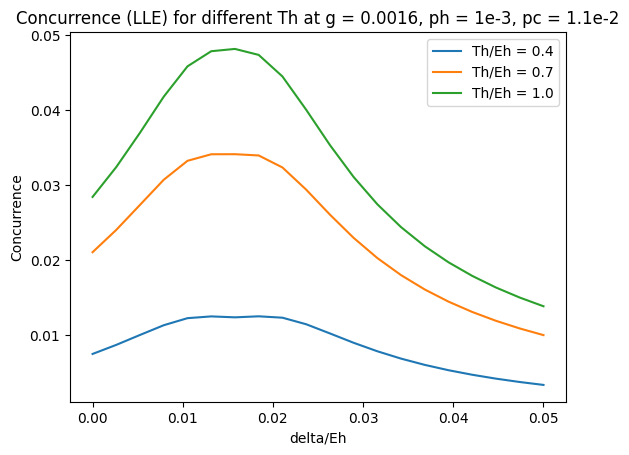

In [54]:
concurrence_plot(Th_list,elist,lle_ss2)

In [55]:
#Let us see the steady state comparisions between the two methods

def dissipator(op,rho):
    return op*rho*op.dag() - 0.5*op.dag()*op*rho - 0.5*rho*op.dag()*op

def l(rho,beta2,e):
    op1 = create_sm(N,1).dag()
    op2 = create_sm(N,N).dag()

    gammah_plus =  gamma1*nbar(1,beta2,mu)
    gammah_minus = gamma1*(nbar(1,beta2,mu)+1)
    gammac_plus = gamma2*nbar(1+e,beta1,mu)  #beta1 is fixed at 1/0.1
    gammac_minus = gamma2*(nbar(1+e,beta1,mu)+1)

    w0list = [1,1+e]

   

    H = create_hamiltonian2(w0list,[g,g],N)
    #print(H.dims)

    H.dims = [[2,2],[2,2]]
    return -1j*(H*rho - rho*H) + gammah_plus*dissipator(op1,rho) + gammah_minus*dissipator(op1.dag(),rho) + gammac_plus*dissipator(op2,rho) + gammac_minus*dissipator(op2.dag(),rho)

def check_ss2(rho_num,rho_th,beta2,e):

    val1 = l(rho_num,beta2,e)
    val2 = l(rho_th,beta2,e)

    print("Numerical ss: ",val1)
    print("Theoretical ss: ",val2)
    


In [56]:
i = 1
j = 2

check_ss2(lle_ss[i][j],create_ss(betalist2[i],elist[j]),betalist2[i],elist[j])

Numerical ss:  Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.92973175e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -6.10922513e-19 -5.82758668e-19  0.00000000e+00]
 [ 0.00000000e+00 -5.82758668e-19 -9.48676901e-20  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.03287907e-19]]
Theoretical ss:  Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-4.23516474e-22  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.80914265e-20 -7.72494048e-19  0.00000000e+00]
 [ 0.00000000e+00 -7.72494048e-19  1.35525272e-20  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.77626358e-20]]


In [57]:
def heat_current_h(rho,beta2,e):
    gammah_plus =  gamma1*nbar(1,beta2,mu)
    gammah_minus = gamma1*(nbar(1,beta2,mu)+1)

    op1 = create_sm(N,1).dag()

    op_com = gammah_plus*dissipator(op1,rho) + gammah_minus*dissipator(op1.dag(),rho)
    H_S=create_hamiltonian2([1,1+e],[g,g],N)

    return (H_S*op_com).tr()

def heat_current_c(rho,beta2,e):
    gammac_plus = gamma2*nbar(1+e,beta1,mu)  #beta1 is fixed at 1/0.1
    gammac_minus = gamma2*(nbar(1+e,beta1,mu)+1)

    op2 = create_sm(N,N).dag()

    op_com = gammac_plus*dissipator(op2,rho) + gammac_minus*dissipator(op2.dag(),rho)
    H_S=create_hamiltonian2([1,1+e],[g,g],N)

    return (H_S*op_com).tr()

In [58]:
def heat_current_plot(Th_list,elist,lle_ss):
    for i in range(len(Th_list)):
        current_list = []
        for j in range(len(elist)):
            current_list.append(heat_current_h(lle_ss[i][j],betalist2[i],elist[j]) - heat_current_c(lle_ss[i][j],betalist2[i],elist[j]))
        plt.plot(elist,current_list,label='Th/Eh = '+str(Th_list[i]))

    plt.xlabel('delta/Eh')
    plt.ylabel('Heat current')
    plt.title(f'Heat current (LLE) for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

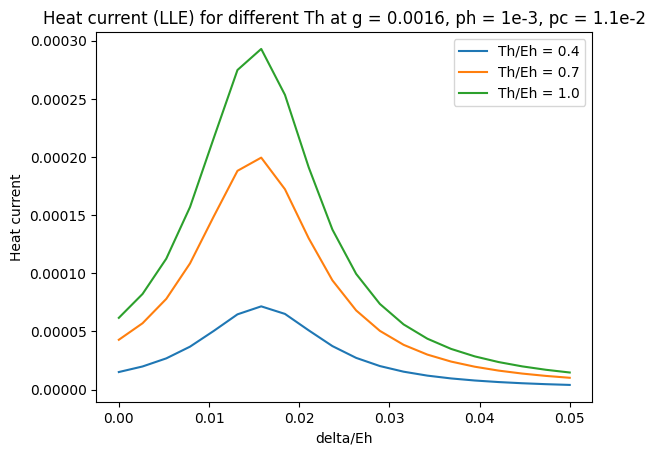

In [59]:
heat_current_plot(Th_list,elist,lle_ss2)

In [60]:
print(Th_list)

[0.4, 0.7, 1.0]


In [61]:
print(elist)

[0.         0.00263158 0.00526316 0.00789474 0.01052632 0.01315789
 0.01578947 0.01842105 0.02105263 0.02368421 0.02631579 0.02894737
 0.03157895 0.03421053 0.03684211 0.03947368 0.04210526 0.04473684
 0.04736842 0.05      ]


In [72]:
def negativity_comp1(Th_list,elist,reduced_dm_list1,reduced_dm_list2):
    for i in range(len(Th_list)-1):
        neg_list1 = []
        neg_list2 = []
        for j in range(len(elist)):
            neg_list1.append(negativity1(reduced_dm_list1[i][j]))
            neg_list2.append(negativity1(reduced_dm_list2[i][j]))
        print(elist)
        plt.plot(elist,neg_list1,'-',label='Th/Eh = '+str(Th_list[i]) + ',LLE')
        plt.plot(elist,neg_list2,'--',label='Th/Eh = '+str(Th_list[i])+',RE')

    plt.xlabel('delta/Eh')
    plt.ylabel('Negativity')
    plt.title(f'Negativity comp for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()



In [63]:
len(lle_ss)

3

[0.         0.00263158 0.00526316 0.00789474 0.01052632 0.01315789
 0.01578947 0.01842105 0.02105263 0.02368421 0.02631579 0.02894737
 0.03157895 0.03421053 0.03684211 0.03947368 0.04210526 0.04473684
 0.04736842 0.05      ]
[0.         0.00263158 0.00526316 0.00789474 0.01052632 0.01315789
 0.01578947 0.01842105 0.02105263 0.02368421 0.02631579 0.02894737
 0.03157895 0.03421053 0.03684211 0.03947368 0.04210526 0.04473684
 0.04736842 0.05      ]
[0.         0.00263158 0.00526316 0.00789474 0.01052632 0.01315789
 0.01578947 0.01842105 0.02105263 0.02368421 0.02631579 0.02894737
 0.03157895 0.03421053 0.03684211 0.03947368 0.04210526 0.04473684
 0.04736842 0.05      ]
[0.         0.00263158 0.00526316 0.00789474 0.01052632 0.01315789
 0.01578947 0.01842105 0.02105263 0.02368421 0.02631579 0.02894737
 0.03157895 0.03421053 0.03684211 0.03947368 0.04210526 0.04473684
 0.04736842 0.05      ]


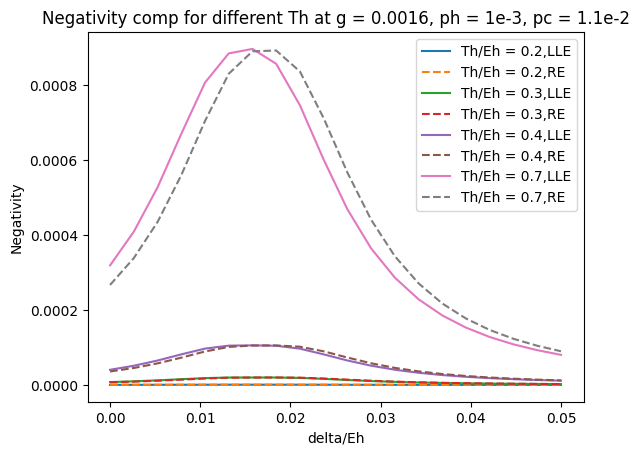

In [73]:
negativity_comp1(Th_list,elist,lle_ss2,redfield_ss)


In [74]:
def curr_comp(Th_list,elist,reduced_dm_list1,reduced_dm_list2):
    for i in range(len(Th_list)):
        curr_list1 = []
        curr_list2 = []
        for j in range(len(elist)):
            curr_list1.append(heat_current_h(reduced_dm_list1[i][j],betalist2[i],elist[j]) - heat_current_c(reduced_dm_list1[i][j],betalist2[i],elist[j]))
            curr_list2.append(heat_current_h(reduced_dm_list2[i][j],betalist2[i],elist[j]) - heat_current_c(reduced_dm_list2[i][j],betalist2[i],elist[j]))
        plt.plot(elist,curr_list1,'-',label='Th/Eh = '+str(Th_list[i]) + ',LLE')
        plt.plot(elist,curr_list2,'--',label='Th/Eh = '+str(Th_list[i])+',RE')

    plt.xlabel('delta/Eh')
    plt.ylabel('Current')
    plt.title(f'Current comp for different Th at g = {g}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

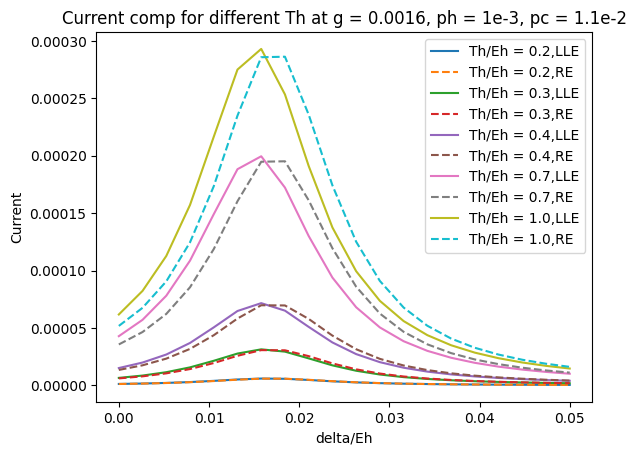

In [75]:
curr_comp(Th_list,elist,lle_ss2,redfield_ss)